In [1]:
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection, naive_bayes, svm
import string
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
import gensim
import gensim.downloader as gensim_api

In [2]:
df = pd.read_csv("dataset.csv")
#DataFlair - Get the labels
labels=df.label
labels.head()

0    False
1     True
2     True
3     True
4     True
Name: label, dtype: bool

In [3]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [4]:
w2vec = get_word2vec(
    MySentences(
        df['finaltext'].values, 
        #df_test['Text'].values  Commented for Kaggle limits
    ),
    'w2vmodel'
)

Found w2vmodel


In [5]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [6]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(df['finaltext'])

AttributeError: 'KeyedVectors' object has no attribute 'syn0'

In [ ]:
#DataFlair - Split the dataset
x_train,x_test,y_train,y_test=train_test_split(x_vecs, labels, test_size=0.2, random_state=7)

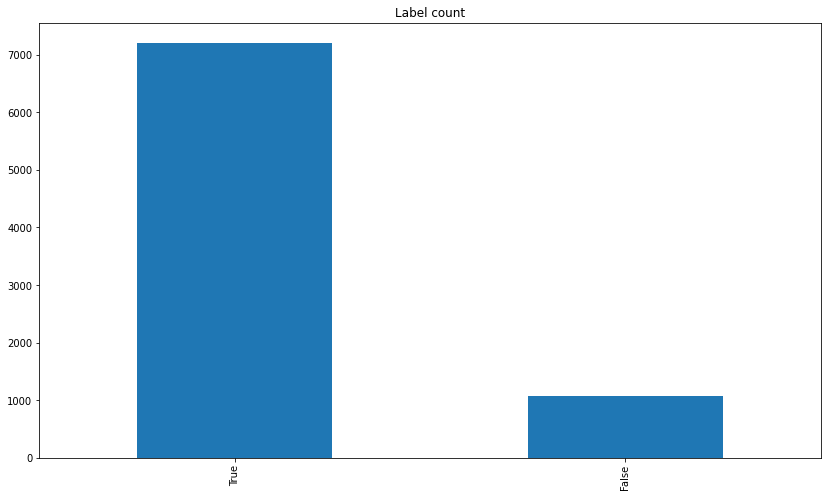

In [ ]:
ax = df['label'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Label count")

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 101)
X_oversample, y_oversample = smote.fit_resample(x_train, y_train)
y_oversample

0         True
1         True
2         True
3         True
4         True
         ...  
11543    False
11544    False
11545    False
11546    False
11547    False
Name: label, Length: 11548, dtype: bool

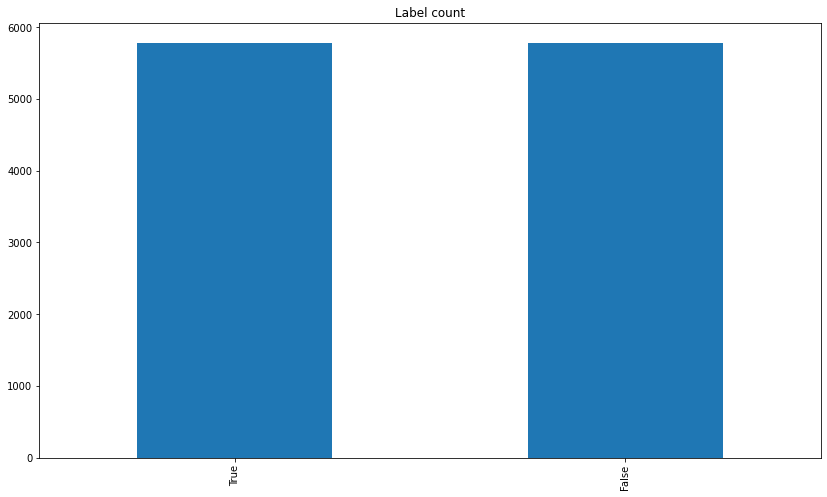

In [ ]:
oversample_df = pd.DataFrame(y_oversample)
ax = oversample_df['label'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Label count")

In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_oversample,y_oversample)# predict the labels on validation dataset
y_pred = SVM.predict(x_test)# Use accuracy_score function to get the accuracy
score=accuracy_score(y_test,y_pred)
print(classification_report(y_test, y_pred))
print(f'Accuracy: {round(score*100,2)}%')
#DataFlair - Build confusion matrix
confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

       False       0.28      0.82      0.41       229
        True       0.96      0.65      0.78      1426

    accuracy                           0.68      1655
   macro avg       0.62      0.74      0.59      1655
weighted avg       0.86      0.68      0.73      1655

Accuracy: 67.67%


array([[188,  41],
       [494, 932]], dtype=int64)